##Task 1 — Anti-Cheat Pre-Filter (Binary Classification)

In [2]:
!pip install catboost scikit-learn pandas numpy matplotlib seaborn optuna tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier

# --------------------
# 1️⃣ Load Data
# --------------------
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

# Drop IDs (non-numeric)
drop_cols = ["id", "player_id"]
train = train.drop(columns=drop_cols, errors="ignore")
test  = test.drop(columns=drop_cols, errors="ignore")

# Drop rows with missing target
train = train.dropna(subset=["is_cheater"])

Train shape: (99872, 34)
Test shape: (25889, 33)


## Quick Exploration


--- Missing Values Analysis ---
Top 10 columns with missing values:

                         Missing Values Count  Missing Values %
reaction_time_ms                        25512             26.10
clutch_success_rate                     24342             24.90
reports_received                        23616             24.16
level                                   23547             24.09
movement_pattern_score                  23350             23.89
game_sense_score                        22340             22.85
level_progression_speed                 18850             19.28
account_age_days                        18148             18.57
input_consistency_score                 17226             17.62
survival_time_avg                       16476             16.86


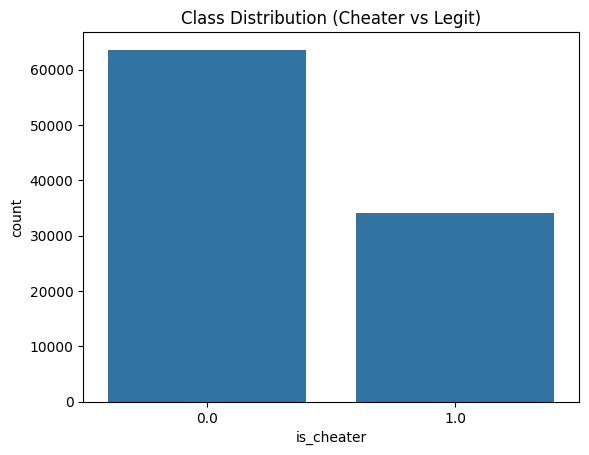

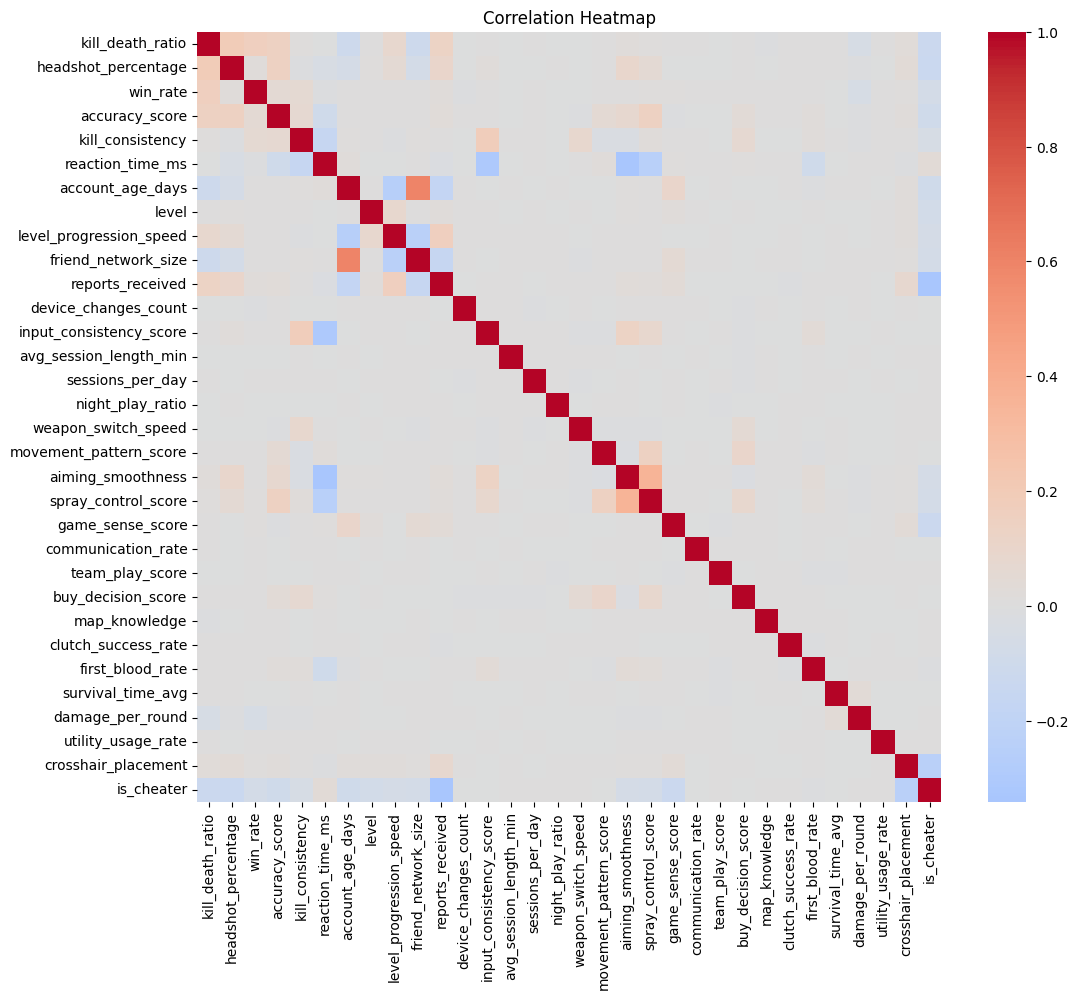

In [5]:
print("\n--- Missing Values Analysis ---")
missing_data = train.isnull().sum()
missing_percent = 100 * train.isnull().sum() / len(train)
missing_table = pd.concat([missing_data, missing_percent], axis=1)
missing_table = missing_table.rename(columns = {0 : 'Missing Values Count', 1 : 'Missing Values %'})
missing_table = missing_table[missing_table['Missing Values Count'] != 0].sort_values(
    'Missing Values %', ascending=False).round(2)

print("Top 10 columns with missing values:\n")
print(missing_table.head(10))

sns.countplot(x="is_cheater", data=train)
plt.title("Class Distribution (Cheater vs Legit)")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(train.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

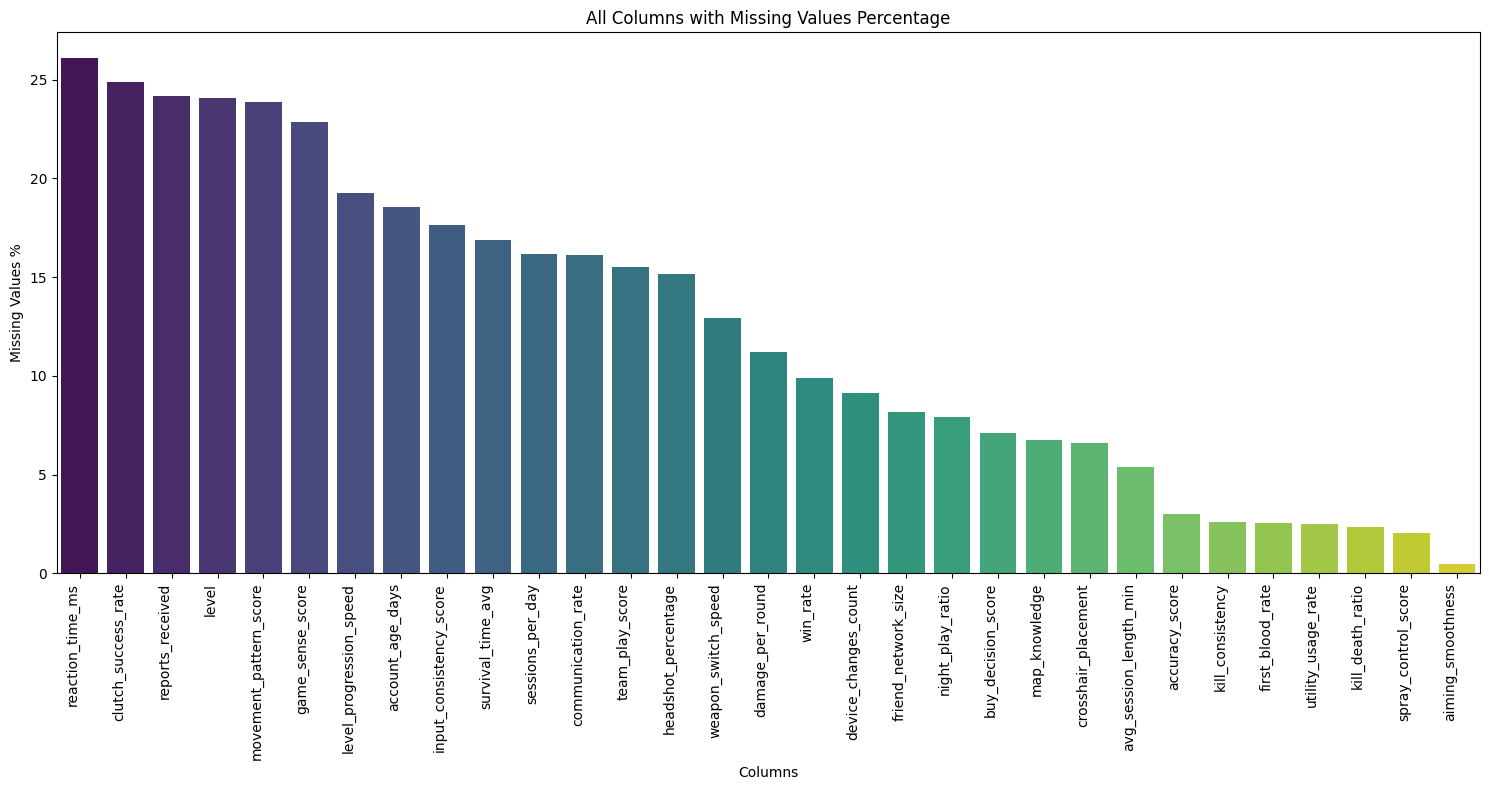

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_table.head(10).index, y='Missing Values %', data=missing_table.head(10), palette='viridis')
plt.title('Top 10 Columns with Missing Values Percentage')
plt.xlabel('Columns')
plt.ylabel('Missing Values %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Cleaning


In [12]:
import numpy as np
import pandas as pd
import warnings

def clean_task1_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and preprocess Task 1 dataset safely:
    - Clip outliers
    - Handle NaN before log transforms
    - Normalize percentage features
    - Fill remaining missing values
    """
    df = df.copy()
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Drop identifiers
    df = df.drop(columns=[c for c in ["id","player_id"] if c in df.columns], errors="ignore")

    # Clip outliers safely
    clip_rules = {
        "kill_death_ratio": (0.5, 8),
        "headshot_percentage": (5, 90),
        "win_rate": (20, 99),
        "reaction_time_ms": (55, 300),
        "level_progression_speed": (0, 2),
        "account_age_days": (1, 1500),
        "avg_session_length_min": (25, 300),
    }
    for col, (low, high) in clip_rules.items():
        if col in df.columns:
            df[col] = np.clip(df[col].fillna(low), low, high)

    # Ensure no negative values before log transform
    for col in ["account_age_days", "level_progression_speed"]:
        if col in df.columns:
            df[col] = np.where(df[col] < 0, 0, df[col])
            df[col] = np.log1p(df[col])

    # Normalize 0–100 features
    for col in ["headshot_percentage", "win_rate", "accuracy_score"]:
        if col in df.columns:
            df[col] = df[col].clip(0, 100) / 100.0

    # Fill missing numerics with median
    df = df.fillna(df.median(numeric_only=True))

    return df


                               mean        min         max        std
kill_death_ratio           4.592551   0.500000    8.000000   1.521527
headshot_percentage        0.413610   0.050000    0.900000   0.199238
win_rate                   0.662848   0.200000    0.990000   0.202465
accuracy_score             0.401220   0.080000    0.850000   0.119458
kill_consistency           0.648630   0.250000    0.980000   0.148960
reaction_time_ms         113.875821  55.000000  300.000000  55.166271
account_age_days           4.829464   0.693147    7.313782   2.232783
level                     62.814528  25.000258   99.999222  18.052602
level_progression_speed    0.146177   0.000000    1.098612   0.235965
friend_network_size      137.874944   0.000000  349.000000  81.411176


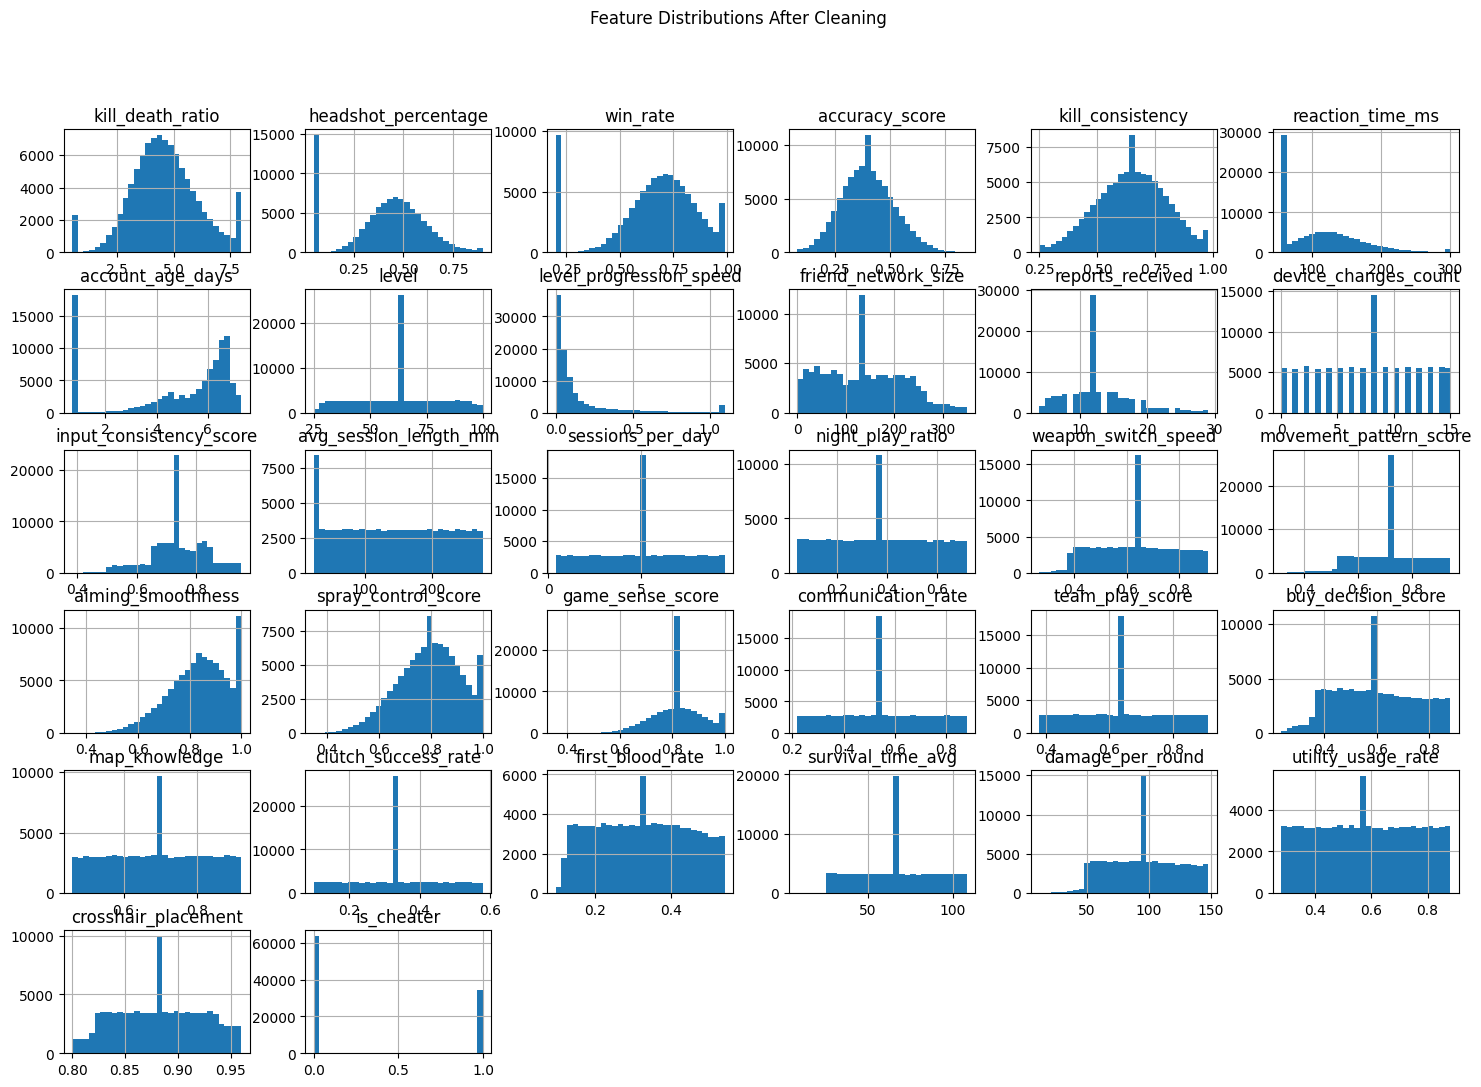

In [13]:
train_clean = clean_task1_data(train)
test_clean  = clean_task1_data(test)

print(train_clean.describe().T[['mean','min','max','std']].head(10))

train_clean.hist(figsize=(18,12), bins=30)
plt.suptitle("Feature Distributions After Cleaning")
plt.show()


##Feature Engineering

In [14]:
#feat eng

def add_features(df):
    df["combat_efficiency"] = (
        df["kill_death_ratio"] * df["accuracy_score"] * df["win_rate"]
    )
    df["mechanical_control"] = (
        df[["aiming_smoothness","spray_control_score","movement_pattern_score"]].mean(axis=1)
    )
    df["team_behavior"] = (
        df[["communication_rate","team_play_score"]].mean(axis=1)
    )
    df["alert_ratio"] = df["reports_received"] / (df["friend_network_size"] + 1)
    return df

train_clean = add_features(train_clean)
test_clean  = add_features(test_clean)


In [15]:
### 1. AGE SEGMENT
train_clean["age_group"] = pd.qcut(train_clean["account_age_days"], q=4, labels=False)
test_clean["age_group"]  = pd.qcut(test_clean["account_age_days"],  q=4, labels=False)

for col in ["kill_death_ratio", "accuracy_score", "win_rate"]:
    train_clean[f"{col}_z_age"] = train_clean.groupby("age_group")[col].transform(
        lambda s: (s - s.mean()) / (s.std() + 1e-6)
    )
    test_clean[f"{col}_z_age"] = test_clean.groupby("age_group")[col].transform(
        lambda s: (s - s.mean()) / (s.std() + 1e-6)
    )


### 2. SKILL SEGMENT
train_clean["skill_score"] = (
    train_clean["kill_death_ratio"]*0.4 +
    train_clean["accuracy_score"]*0.3 +
    train_clean["win_rate"]*0.3
)
test_clean["skill_score"] = (
    test_clean["kill_death_ratio"]*0.4 +
    test_clean["accuracy_score"]*0.3 +
    test_clean["win_rate"]*0.3
)

train_clean["skill_group"] = pd.qcut(train_clean["skill_score"], q=4, labels=False)
test_clean["skill_group"]  = pd.qcut(test_clean["skill_score"],  q=4, labels=False)

for col in ["reaction_time_ms", "level_progression_speed"]:
    train_clean[f"{col}_z_skill"] = train_clean.groupby("skill_group")[col].transform(
        lambda s: (s - s.mean()) / (s.std() + 1e-6)
    )
    test_clean[f"{col}_z_skill"] = test_clean.groupby("skill_group")[col].transform(
        lambda s: (s - s.mean()) / (s.std() + 1e-6)
    )


##Training Catboost Model with Optuna



In [16]:
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier


In [18]:
X = train_clean.drop("is_cheater", axis=1)
y = train_clean["is_cheater"]

In [19]:
def tune_threshold(y_true, probs):
    # fewer thresholds → less overfitting
    thresholds = np.arange(0.25, 0.66, 0.05)

    best_f2, best_t = -1, 0.5
    for t in thresholds:
        preds = (probs > t).astype(int)
        f2 = fbeta_score(y_true, preds, beta=2)
        if f2 > best_f2:
            best_f2, best_t = f2, t
    return best_f2, best_t


In [20]:
def objective(trial):

    # IMPORTANT: reduce search space → less overfitting
    params = {
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "iterations": trial.suggest_int("iterations", 1500, 3500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.04),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 15),
        "border_count": trial.suggest_int("border_count", 64, 200),
        "random_strength": trial.suggest_float("random_strength", 0, 1.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 3),
        "task_type": "GPU",
        "verbose": False,
    }

    # tune class weight (extremely important for F2)
    pos_w = trial.suggest_float("pos_weight", 1.0, 3.0)
    params["class_weights"] = [1, pos_w]

    # SMALL CV for speed + stability
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Evaluate using CV average F2
    f2_scores = []

    for tr_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=150, verbose=False)

        probs = model.predict_proba(X_val)[:, 1]

        # threshold tuning INSIDE CV (LESS OVERFITTING)
        f2, t = tune_threshold(y_val, probs)

        f2_scores.append(f2)

    # Anti-overfitting trick: return *mean* not max
    return np.mean(f2_scores)



In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)   # increase to 50–100 later

print("🔥 Best F2:", study.best_value)
print("🔥 Best Params:", study.best_params)

best_params = study.best_params.copy()
pos_weight = best_params.pop("pos_weight")

params = {
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "task_type": "GPU",
    "random_seed": 42,
    "verbose": False,
    "class_weights": [1, pos_weight],
    **best_params
}

[I 2025-11-23 11:40:59,346] A new study created in memory with name: no-name-dab1039f-5b14-4944-a18f-3ac4c0371d85
[I 2025-11-23 11:41:42,121] Trial 0 finished with value: 0.8383257935209332 and parameters: {'iterations': 1765, 'learning_rate': 0.0335996591214939, 'depth': 6, 'l2_leaf_reg': 5.901224322374468, 'border_count': 161, 'random_strength': 0.5088107799809435, 'bagging_temperature': 0.3930505731494862, 'pos_weight': 2.9847250136771057}. Best is trial 0 with value: 0.8383257935209332.
[I 2025-11-23 11:42:26,561] Trial 1 finished with value: 0.835029636708165 and parameters: {'iterations': 3194, 'learning_rate': 0.03218821322145308, 'depth': 8, 'l2_leaf_reg': 12.513901172444333, 'border_count': 197, 'random_strength': 0.4565146365116046, 'bagging_temperature': 2.0708797684251277, 'pos_weight': 2.539496725983188}. Best is trial 0 with value: 0.8383257935209332.
[I 2025-11-23 11:43:34,236] Trial 2 finished with value: 0.8304137098444221 and parameters: {'iterations': 2675, 'learning

🔥 Best F2: 0.8387807015160403
🔥 Best Params: {'iterations': 2255, 'learning_rate': 0.03580241030302626, 'depth': 9, 'l2_leaf_reg': 3.635634163802371, 'border_count': 185, 'random_strength': 0.6221184036144747, 'bagging_temperature': 0.4503551838116119, 'pos_weight': 2.731038610615715}


##FINAL 5-FOLD CV (stable)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_probs = np.zeros(len(X))
models = []
thresholds = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):

    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val),
              early_stopping_rounds=200, verbose=False)

    probs = model.predict_proba(X_val)[:, 1]
    oof_probs[val_idx] = probs

    f2, t = tune_threshold(y_val, probs)
    thresholds.append(t)

    print(f"Fold {fold}: F2 = {f2:.4f}, Best T = {t:.2f}")
    models.append(model)

# global threshold chosen AFTER oof (anti-overfit)
global_f2, global_t = tune_threshold(y, oof_probs)
print("\nFINAL Threshold:", global_t)
print("FINAL OOF F2:", global_f2)


Fold 1: F2 = 0.8383, Best T = 0.30
Fold 2: F2 = 0.8385, Best T = 0.35
Fold 3: F2 = 0.8390, Best T = 0.30
Fold 4: F2 = 0.8342, Best T = 0.30
Fold 5: F2 = 0.8438, Best T = 0.40

FINAL Threshold: 0.35
FINAL OOF F2: 0.8381634334052585


In [23]:
test_preds = np.mean([m.predict(test_clean) for m in models], axis=0).round().astype(int)
submission = pd.DataFrame({
    "id": np.arange(1, len(test_preds)+1),
    "is_cheater": test_preds
})
submission.to_csv("submission.csv", index=False)
print("🚀 submission.csv created successfully!")
submission.head()

🚀 submission.csv created successfully!


,id,is_cheater
0,1,1
1,2,0
2,3,1
3,4,0
4,5,1


##Feature Importance

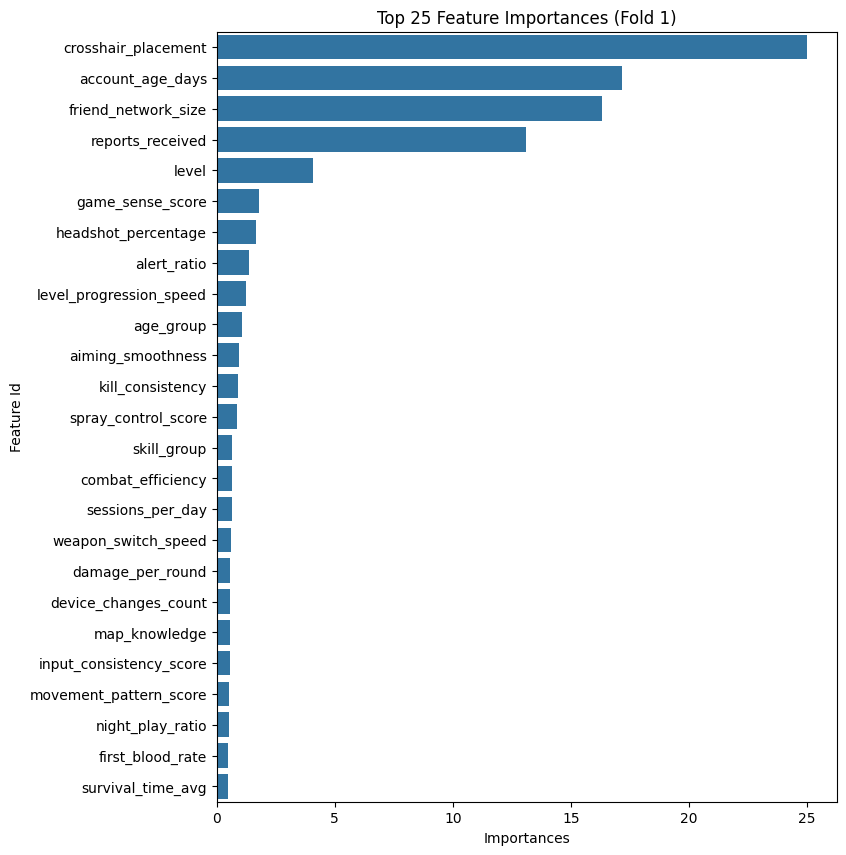

In [24]:
importances = models[0].get_feature_importance(prettified=True)
plt.figure(figsize=(8,10))
sns.barplot(y='Feature Id', x='Importances', data=importances.sort_values(by='Importances', ascending=False).head(25))
plt.title("Top 25 Feature Importances (Fold 1)")
plt.show()